In [ ]:
!git clone https://github.com/MCG-NJU/VideoMAE.git

Cloning into 'VideoMAE'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 314 (delta 103), reused 89 (delta 89), pack-reused 182 (from 1)
Receiving objects: 100% (314/314), 583.05 KiB | 2.18 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm==0.4.12
!DS_BUILD_OPS=1 pip install deepspeed==0.5.8
!pip install tensorboardX
!pip install decord
!pip install einops

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu111 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.0+cu121.with.pypi.cudnn, 2.1.0+rocm5.5, 2.1.0+rocm5.6, 2.1.1, 2.1.1+cpu, 2.1.1+cpu.cxx11.abi, 2.1.1+cu118, 2.1.1+cu121, 2.1.1+cu121.with.pypi.cudnn, 2.1.1+rocm5.5, 2.1.1+rocm5.6, 2.1.2, 2.1.2+cpu, 2.1.2+cpu.cxx11.abi, 2.1.2+cu118, 2.1.2+cu121, 2.1.2+cu121.with.pypi.cudnn, 2.1.2+rocm5.5, 2.1.2+rocm5.6, 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0

In [ ]:
# Set the path to save video
OUTPUT_DIR='/content/'
# path to video for visualization
VIDEO_PATH='/content/video.mp4'
# path to pretrain model
MODEL_PATH='/content/checkpoint.pth'

!python3 /content/VideoMAE/run_videomae_vis.py \
    --mask_ratio 0.9 \
    --mask_type tube \
    --decoder_depth 4 \
    --model pretrain_videomae_base_patch16_224 \
    {VIDEO_PATH} {OUTPUT_DIR} {MODEL_PATH}

Namespace(img_path='/content/video.mp4', save_path='/content/', model_path='/content/checkpoint.pth', mask_type='tube', num_frames=16, sampling_rate=4, decoder_depth=4, input_size=224, device='cuda:0', imagenet_default_mean_and_std=True, mask_ratio=0.9, model='pretrain_videomae_base_patch16_224', drop_path=0.0)
Creating model: pretrain_videomae_base_patch16_224
Patch size = (16, 16)
/content/VideoMAE/run_videomae_vis.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode u

In [19]:
import av
import numpy as np

from transformers import AutoImageProcessor, TimesformerModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = "/content/eating_spaghetti.mp4"
container = av.open(file_path)

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate=4, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

# forward pass
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions
last_layer_attentions = attentions[-1]
print(last_layer_attentions.shape)

torch.Size([8, 12, 197, 197])


In [20]:
video.shape

(8, 360, 640, 3)

In [21]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Chuyển tensor attention về CPU nếu cần
attn = last_layer_attentions.detach().cpu()  # shape: (B, H, 197, 197)
B, num_heads, seq_len, _ = attn.shape

# Danh sách lưu heatmap cho từng frame
heatmaps = []

for i in range(B):
    # Lấy attention của token CLS (index 0) đến các patch tokens (indices 1:197)
    # Kết quả có shape (num_heads, 196)
    attn_frame = attn[i, :, 0, 1:]

    # Tính trung bình attention qua các head, kết quả shape: (196,)
    attn_avg = attn_frame.mean(dim=0)

    # Chuẩn hóa attention (đưa về khoảng [0, 1])
    attn_norm = (attn_avg - attn_avg.min()) / (attn_avg.max() - attn_avg.min() + 1e-8)

    # Reshape thành lưới 14 x 14 (vì 196 = 14*14)
    attn_grid = attn_norm.reshape(14, 14)

    # Chuyển sang tensor 4D (1, 1, 14, 14) để sử dụng hàm interpolate
    attn_grid = attn_grid.unsqueeze(0).unsqueeze(0)

    # Phóng to (interpolate) lên kích thước của ảnh gốc, ví dụ: 224 x 224
    attn_up = F.interpolate(attn_grid, size=(224, 224), mode="bilinear", align_corners=False)
    attn_up = attn_up.squeeze().numpy()  # shape: (224, 224)

    heatmaps.append(attn_up)

# Sau đó, ta có thể overlay heatmap lên ảnh gốc.
# Giả sử `video` là mảng numpy chứa các frame gốc với định dạng RGB.
overlay_images = []

for i in range(B):
    # Lấy frame gốc (RGB)
    frame = video[i]  # shape: (H, W, 3), ví dụ H=W=224
    # Chuyển heatmap sang 8-bit [0, 255]
    heatmap = (heatmaps[i] * 255).astype(np.uint8)
    # Sử dụng OpenCV để áp dụng colormap (ví dụ: COLORMAP_JET)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Resize heatmap_color to match the size of the frame
    heatmap_color_resized = cv2.resize(heatmap_color, (frame.shape[1], frame.shape[0]))

    # Chuyển đổi frame từ RGB sang BGR (theo chuẩn của OpenCV)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # Blend (trộn) ảnh gốc với heatmap, thay đổi tham số alpha để điều chỉnh mức độ overlay
    overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color_resized, 0.4, 0) # Use resized heatmap
    overlay_images.append(overlay)


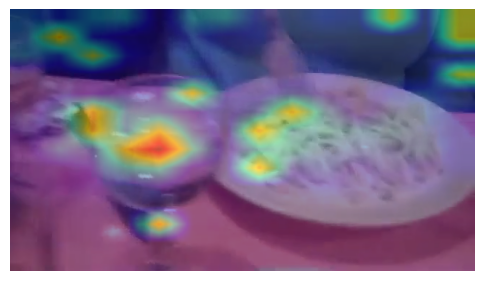

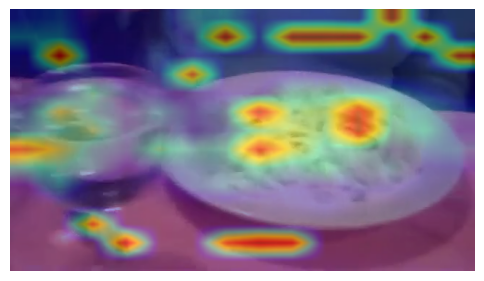

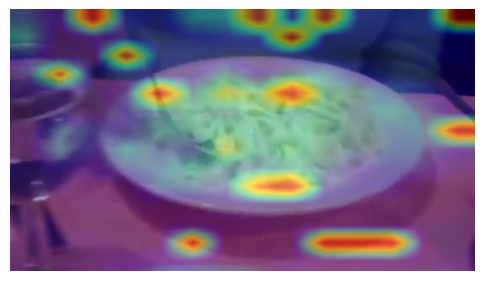

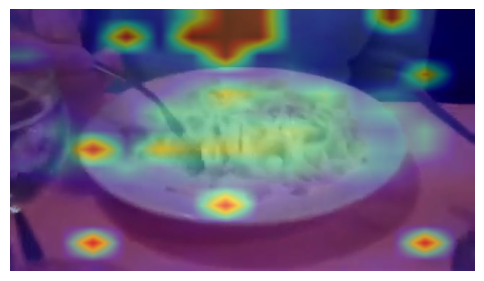

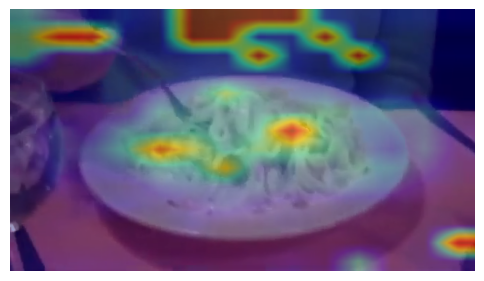

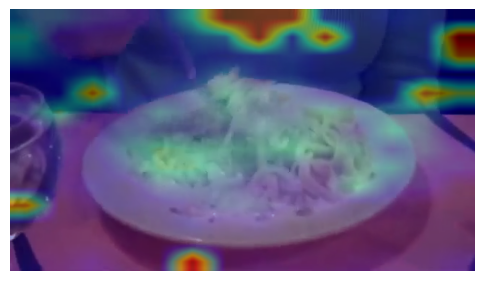

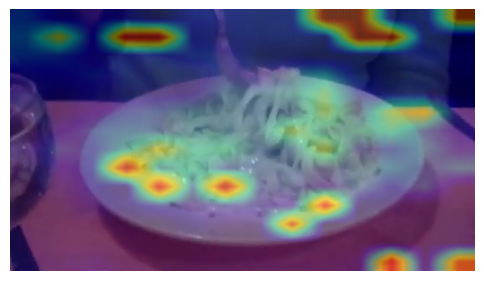

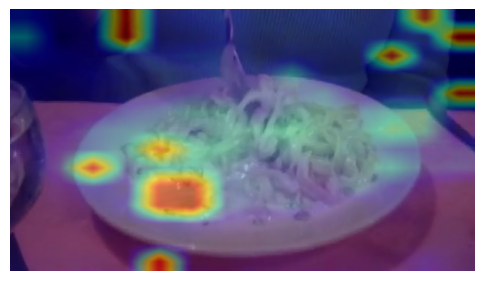

In [22]:
for i in range(B):
    # Ví dụ: hiển thị frame đầu tiên có overlay
    plt.figure(figsize=(6, 6))
    # Chuyển lại từ BGR sang RGB để hiển thị đúng màu
    plt.imshow(cv2.cvtColor(overlay_images[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

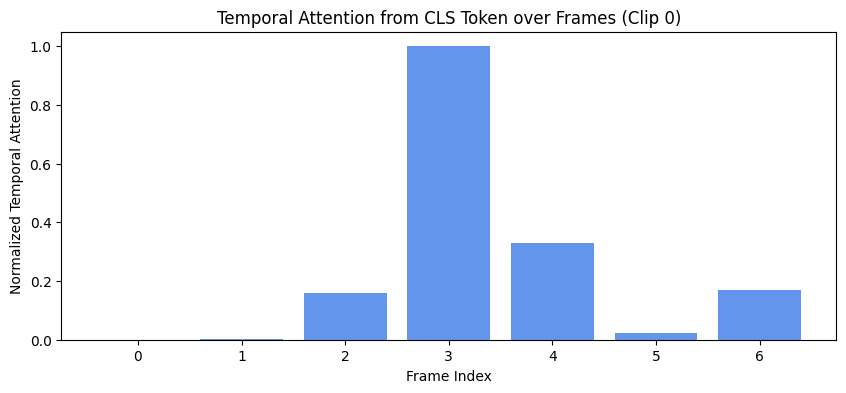

In [27]:
import torch
import matplotlib.pyplot as plt

# Giả sử last_attentions có shape: (B, num_heads, L, L) = (8, 12, 197, 197)
B, num_heads, L, _ = last_attentions.shape

# Ta có L - 1 = 196 token patch. Chọn T = 7, vậy P = 196 / 7 = 28
T = 7
P = (L - 1) // T  # 196 // 7 = 28

# Xử lý clip đầu tiên trong batch
attn_clip = last_attentions[0]  # shape: (12, 197, 197)

# Lấy attention từ token [CLS] (index 0) đến các patch tokens (indices 1:197)
# Kết quả có shape: (12, 196)
cls_attn = attn_clip[:, 0, 1:]

# Reshape thành (num_heads, T, P) = (12, 7, 28)
cls_attn = cls_attn.reshape(num_heads, T, P)

# Tính trung bình attention qua các patch cho mỗi frame, cho mỗi head
time_attn_per_head = cls_attn.mean(dim=-1)  # shape: (12, 7)

# Tính trung bình qua các head để có vector attention theo thời gian (7 frame)
avg_time_attn = time_attn_per_head.mean(dim=0)  # shape: (7,)
avg_time_attn = (avg_time_attn - avg_time_attn.min()) / (avg_time_attn.max() - avg_time_attn.min() + 1e-8)
plt.figure(figsize=(10, 4))
plt.bar(range(T), avg_time_attn.detach().cpu().numpy(), color='cornflowerblue')
plt.xlabel("Frame Index")
plt.ylabel("Normalized Temporal Attention")
plt.title("Temporal Attention from CLS Token over Frames (Clip 0)")
plt.show()


In [ ]:
import av
import numpy as np

from transformers import VivitImageProcessor, VivitModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
container = av.open(file_path)

# sample 32 frames
indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

# forward pass
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)